# Imports

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Device Configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Image Transforms

In [3]:
IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),          # [0,1]
])


# LOAD & EXPLORE DATASET
## Custom Dataset (No Labels) 

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


# LOAD DATASET

In [5]:
IMAGE_DIR = "/kaggle/input/product-images-dataset/small/01"

dataset = ImageDataset(IMAGE_DIR, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


# VISUALIZE RANDOM IMAGES (SANITY CHECK)

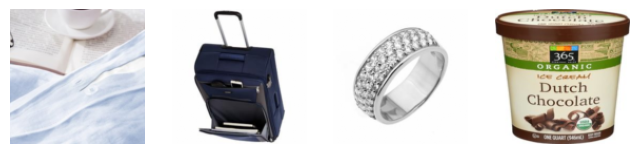

In [6]:
images = next(iter(dataloader))

plt.figure(figsize=(8,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.axis("off")
plt.show()


# DEFINE CNN AUTOENCODER (FROM SCRATCH)
## Encoder (Feature Extractor)

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 128)   # embedding vector
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


## Decoder (For Reconstruction)

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(128, 128 * 16 * 16),
            nn.ReLU()
        )

        self.deconv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 16, 16)
        x = self.deconv(x)
        return x


## Autoencoder Wrapper

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


# INITIALIZE MODEL

In [10]:
model = Autoencoder().to(device)


# LOSS & OPTIMIZER

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# TRAIN THE AUTOENCODER

In [12]:
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    for images in dataloader:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss:.4f}")


Epoch [1/30], Loss: 6.6568
Epoch [2/30], Loss: 4.0222
Epoch [3/30], Loss: 3.1653
Epoch [4/30], Loss: 2.7584
Epoch [5/30], Loss: 2.5443
Epoch [6/30], Loss: 2.3612
Epoch [7/30], Loss: 2.1744
Epoch [8/30], Loss: 2.0388
Epoch [9/30], Loss: 1.8841
Epoch [10/30], Loss: 1.7494
Epoch [11/30], Loss: 1.6324
Epoch [12/30], Loss: 1.5746
Epoch [13/30], Loss: 1.4711
Epoch [14/30], Loss: 1.4115
Epoch [15/30], Loss: 1.3665
Epoch [16/30], Loss: 1.2867
Epoch [17/30], Loss: 1.2729
Epoch [18/30], Loss: 1.2168
Epoch [19/30], Loss: 1.1914
Epoch [20/30], Loss: 1.1286
Epoch [21/30], Loss: 1.0500
Epoch [22/30], Loss: 1.0251
Epoch [23/30], Loss: 0.9778
Epoch [24/30], Loss: 0.9358
Epoch [25/30], Loss: 0.9124
Epoch [26/30], Loss: 0.8971
Epoch [27/30], Loss: 0.9048
Epoch [28/30], Loss: 0.8663
Epoch [29/30], Loss: 0.8346
Epoch [30/30], Loss: 0.8043


# EXTRACT PRODUCT EMBEDDINGS

In [13]:
model.eval()

embeddings = []
image_names = dataset.image_files

with torch.no_grad():
    for images in dataloader:
        images = images.to(device)
        z = model.encoder(images)
        embeddings.append(z.cpu().numpy())

embeddings = np.vstack(embeddings)


# PROCESS USER-UPLOADED IMAGE

In [6]:
def process_query_image(path):
    image = Image.open(path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    return image


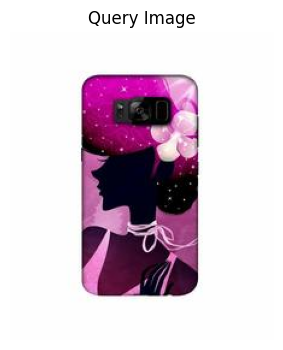

In [8]:
query_image = process_query_image("/kaggle/input/product-images-dataset/small/01/01013f05.jpg")

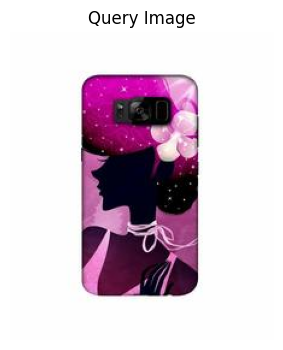

In [9]:
img = Image.open("/kaggle/input/product-images-dataset/small/01/01013f05.jpg").convert("RGB")

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")
plt.title("Query Image")
plt.show()

# COMPUTE SIMILARITY

In [16]:
with torch.no_grad():
    query_embedding = model.encoder(query_image).cpu().numpy()


In [17]:
similarity = cosine_similarity(query_embedding, embeddings)

# TOP-N RECOMMENDATIONS

In [18]:
TOP_N = 5
top_indices = similarity[0].argsort()[-TOP_N:][::-1]


# SHOW RECOMMENDED IMAGES

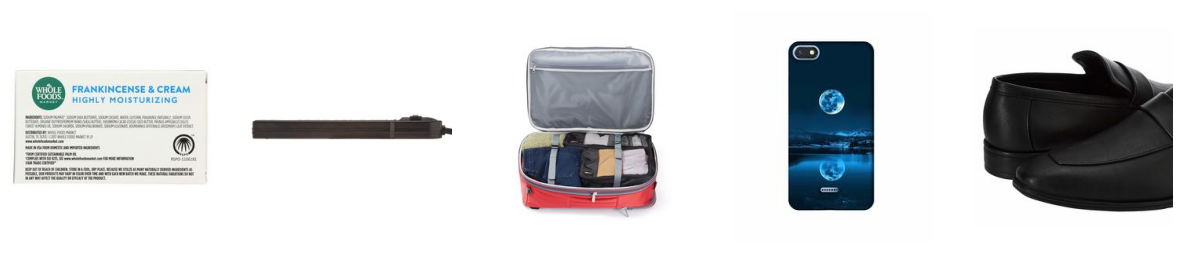

In [19]:
plt.figure(figsize=(15,5))

for i, idx in enumerate(top_indices):
    img_path = os.path.join(IMAGE_DIR, image_names[idx])
    img = Image.open(img_path)

    plt.subplot(1, TOP_N, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.show()
